<a href="https://colab.research.google.com/github/faizankshaikh/ForaGym/blob/main/notebooks/DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Installation

In [1]:
#@title install required libraries
# !git clone --quiet https://github.com/faizankshaikh/ForaGym.git
# %cd ForaGym/
# !pip install -q gymnasium shap

/content/ForaGym


# 2. Create Gym environment

In [2]:
#@title import required libs and modules
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import gymnasium as gym
import matplotlib.pyplot as plt

from glob import glob
from sklearn import tree
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [3]:
#@title initiatlize gym env
env_verbose = gym.make(
    "foragym:foragym/ForaGym-v1",
    render_mode="human"
)

env = gym.make(
    "foragym:foragym/ForaGym-v1",
    render_mode=None
)

# 3. Explain Human Behavioud using Observations

In [4]:
#@title Connect GDrive
from google.colab import drive
drive.mount('/content/drive')

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#@title Unpack data of participants
!unzip "/content/drive/MyDrive/MAID/Internship DNHI/experiments/DATA.zip"

Archive:  /content/drive/MyDrive/MAID/Internship DNHI/experiments/DATA.zip
replace DATA/test_data.ae11.CAT_single.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
#@title Get relevant CSVs
exps = [f for f in glob("DATA/*.csv") if "single" in f]
exps

['DATA/test_data.lb11.CAT_single.csv',
 'DATA/test_data.pz19.CAT_single.csv',
 'DATA/test_data.qh13.CAT_single.csv',
 'DATA/test_data.kp4.CAT_single.csv',
 'DATA/test_data.ti14.CAT_single.csv',
 'DATA/test_data.nx8.CAT_single.csv',
 'DATA/test_data.xs3.CAT_single.csv',
 'DATA/test_data.oy13.CAT_single.csv',
 'DATA/test_data.wp8.CAT_single.csv',
 'DATA/test_data.ri12.CAT_single.csv',
 'DATA/test_data.bh3.CAT_single.csv',
 'DATA/test_data.rn14.CAT_single.csv',
 'DATA/test_data.iz8.CAT_single.csv',
 'DATA/test_data.sn16.CAT_single.csv',
 'DATA/test_data.pt3.CAT_single.csv',
 'DATA/test_data.ry1.CAT_single.csv',
 'DATA/test_data.tb12.CAT_single.csv',
 'DATA/test_data.zu11.CAT_single.csv',
 'DATA/test_data.uk5.CAT_single.csv',
 'DATA/test_data.os8.CAT_single.csv',
 'DATA/test_data.or1.CAT_single.csv',
 'DATA/test_data.ae11.CAT_single.csv',
 'DATA/test_data.xp7.CAT_single.csv',
 'DATA/test_data.ox19.CAT_single.csv',
 'DATA/test_data.sd9.CAT_single.csv',
 'DATA/test_data.xt17.CAT_single.csv',

In [7]:
#@title Create dataset for model building
X = []
X_OP = []
y = []

feature_names = [
    "days_left",
    "in_LP",           # life_points_left
    "p_succ_correct",  # forest_quality * (1 - threat_encounter)
    "r_threat",        # threat_encounter
    "gain_if_succ",    # nutritional_quality
    "safe_state"       # life_points_left > days_left
]

target_names = ["wait", "forage"]

for f in exps:
    data = pd.read_csv(f)
    data_cleaned = data.dropna(subset=["day.thisRepN"]).copy()
    data_cleaned.drop(
        data_cleaned[data_cleaned["foraging T/F COPY"].astype("str") == "None"].index,
        inplace=True,
    )

    data_cleaned["days_left"] = data_cleaned["day.thisRepN"].apply(lambda x: 8 - x)

    data_cleaned["action"] = (
        data_cleaned["foraging T/F"]
        .astype("str")
        .map({"True": True, "TRUE": True, "False": False, "FALSE": False})
        .astype(int)
    )
    data_cleaned["safe_state"] = data_cleaned.apply(
        lambda row: (row["in_LP"] > row["days_left"]),
        axis=1
    ).astype(int)

    X_arr = data_cleaned[feature_names].values

    X_OP_arr = data_cleaned[["OP_value_difference"]].values

    y_arr = data_cleaned[["action"]].values

    X.append(X_arr)
    X_OP.append(X_OP_arr)
    y.append(y_arr)

X = np.concatenate(X)
X_OP = np.concatenate(X_OP)
y = np.concatenate(y).ravel()

# # optional saving of datasets
# pd.DataFrame(
#     np.concatenate([X, y[:, None]], axis=1),
#     columns=feature_names + ["action"]
# ).to_csv("dataset.csv", index=False)

# pd.DataFrame(
#     np.concatenate([X_OP, y[:, None]], axis=1),
#     columns=["OP_value_diff", "action"]
# ).to_csv("dataset_OP.csv", index=False)

In [8]:
#@title Print shape
X.shape, X_OP.shape, y.shape

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


((10270, 6), (10270, 1), (10270,))

In [9]:
#@title Check data description
feature_names = [
    "days_left",
    "life_points_left",
    "probability_success",
    "probability_threat",
    "nutritional_quality",
    "safe_state"       # life_points_left > days_left
]

df = pd.DataFrame(
    np.concatenate([X, y[:, None]], axis=1),
    columns=feature_names + ["action"]
)

df.describe()

,days_left,life_points_left,probability_success,probability_threat,nutritional_quality,safe_state,action
count,10270.000000,10270.000000,10270.000000,10270.000000,10270.000000,10270.000000,10270.000000
mean,5.516943,3.384518,0.346619,0.194455,1.586173,0.139046,0.517235
std,2.067715,1.461971,0.118957,0.168023,0.492542,0.346011,0.499727
min,1.000000,1.000000,0.160000,0.000000,1.000000,0.000000,0.000000
25%,4.000000,2.000000,0.244898,0.000000,1.000000,0.000000,0.000000
50%,6.000000,3.000000,0.333333,0.200000,2.000000,0.000000,1.000000
75%,7.000000,5.000000,0.444444,0.285714,2.000000,0.000000,1.000000
max,8.000000,6.000000,0.625000,0.666667,2.000000,1.000000,1.000000


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


<Axes: xlabel='days_left'>

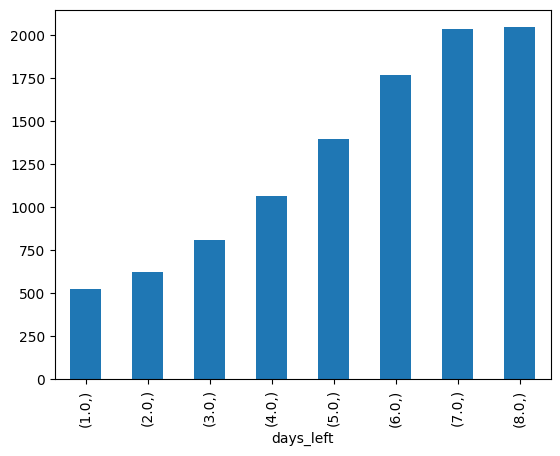

In [10]:
#@title Frequency plot of "days_left"
df.value_counts(["days_left"], sort=False).plot(kind="bar")

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


<Axes: xlabel='life_points_left'>

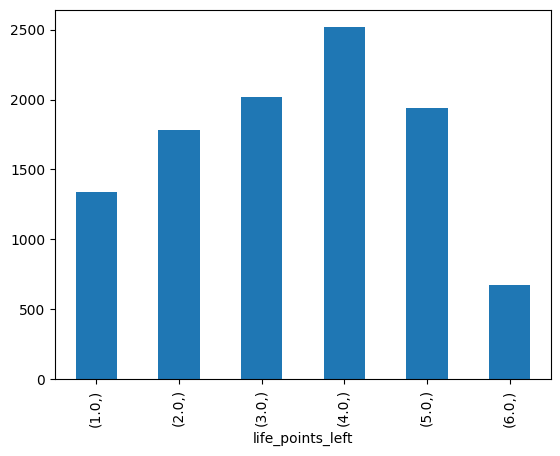

In [11]:
#@title Frequency plot of "life_points_left"
df.value_counts(["life_points_left"], sort=False).plot(kind="bar")

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


<Axes: xlabel='days_left'>

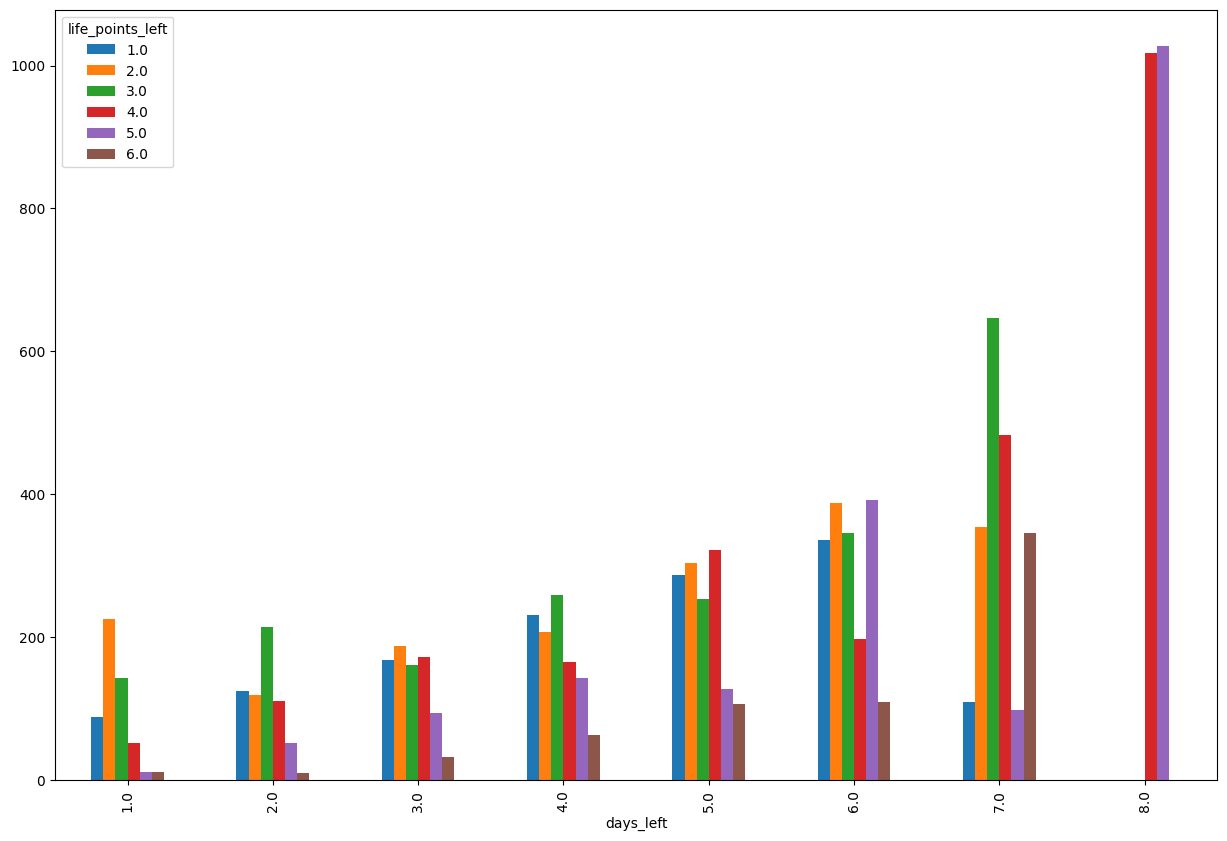

In [12]:
#@title Frequency plot of "days_left" along with "life_points_left"
df.value_counts(["days_left", "life_points_left"], sort=False).unstack().plot(kind="bar", figsize=(15, 10))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


<Axes: xlabel='days_left'>

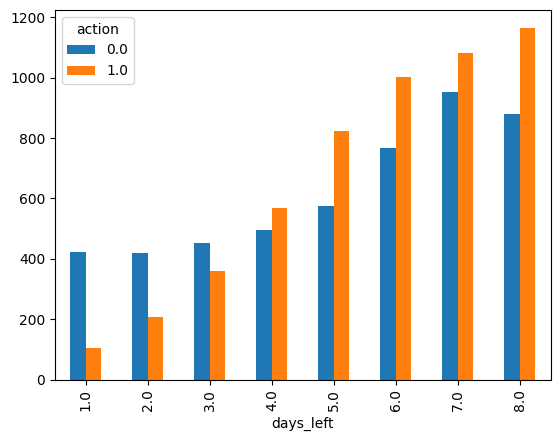

In [13]:
#@title Frequency plot of "days_left" for a particular "action"
df.value_counts(["days_left", "action"], sort=False).unstack().plot(kind="bar")

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


<Axes: xlabel='life_points_left'>

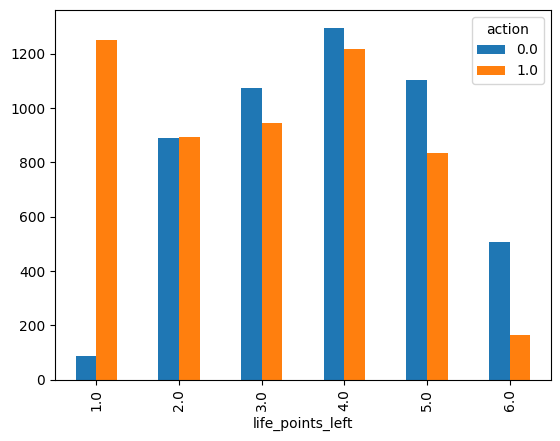

In [14]:
#@title Frequency plot of "life_points_left" for a particular "action"
df.value_counts(["life_points_left", "action"], sort=False).unstack().plot(kind="bar")

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


<Axes: title={'center': 'probability_success'}, xlabel='action'>

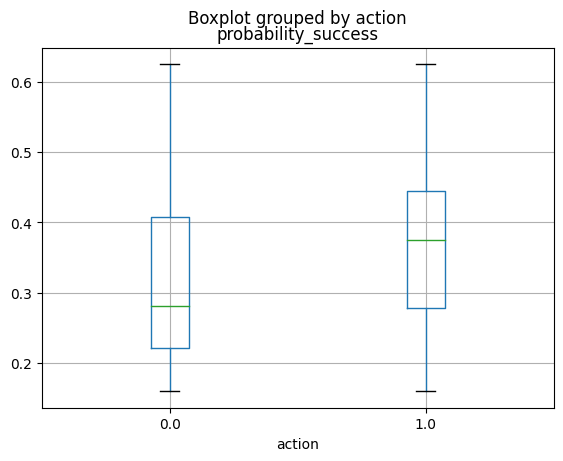

In [15]:
#@title Box plot of "probability_success" for a particular "action"
df.boxplot("probability_success", "action")

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


<Axes: title={'center': 'probability_threat'}, xlabel='action'>

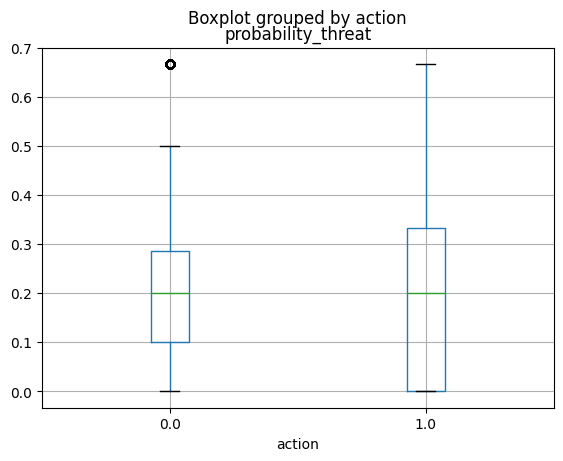

In [16]:
#@title Box plot of "probability_threat" for a particular "action"
df.boxplot("probability_threat", "action")

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


<Axes: >

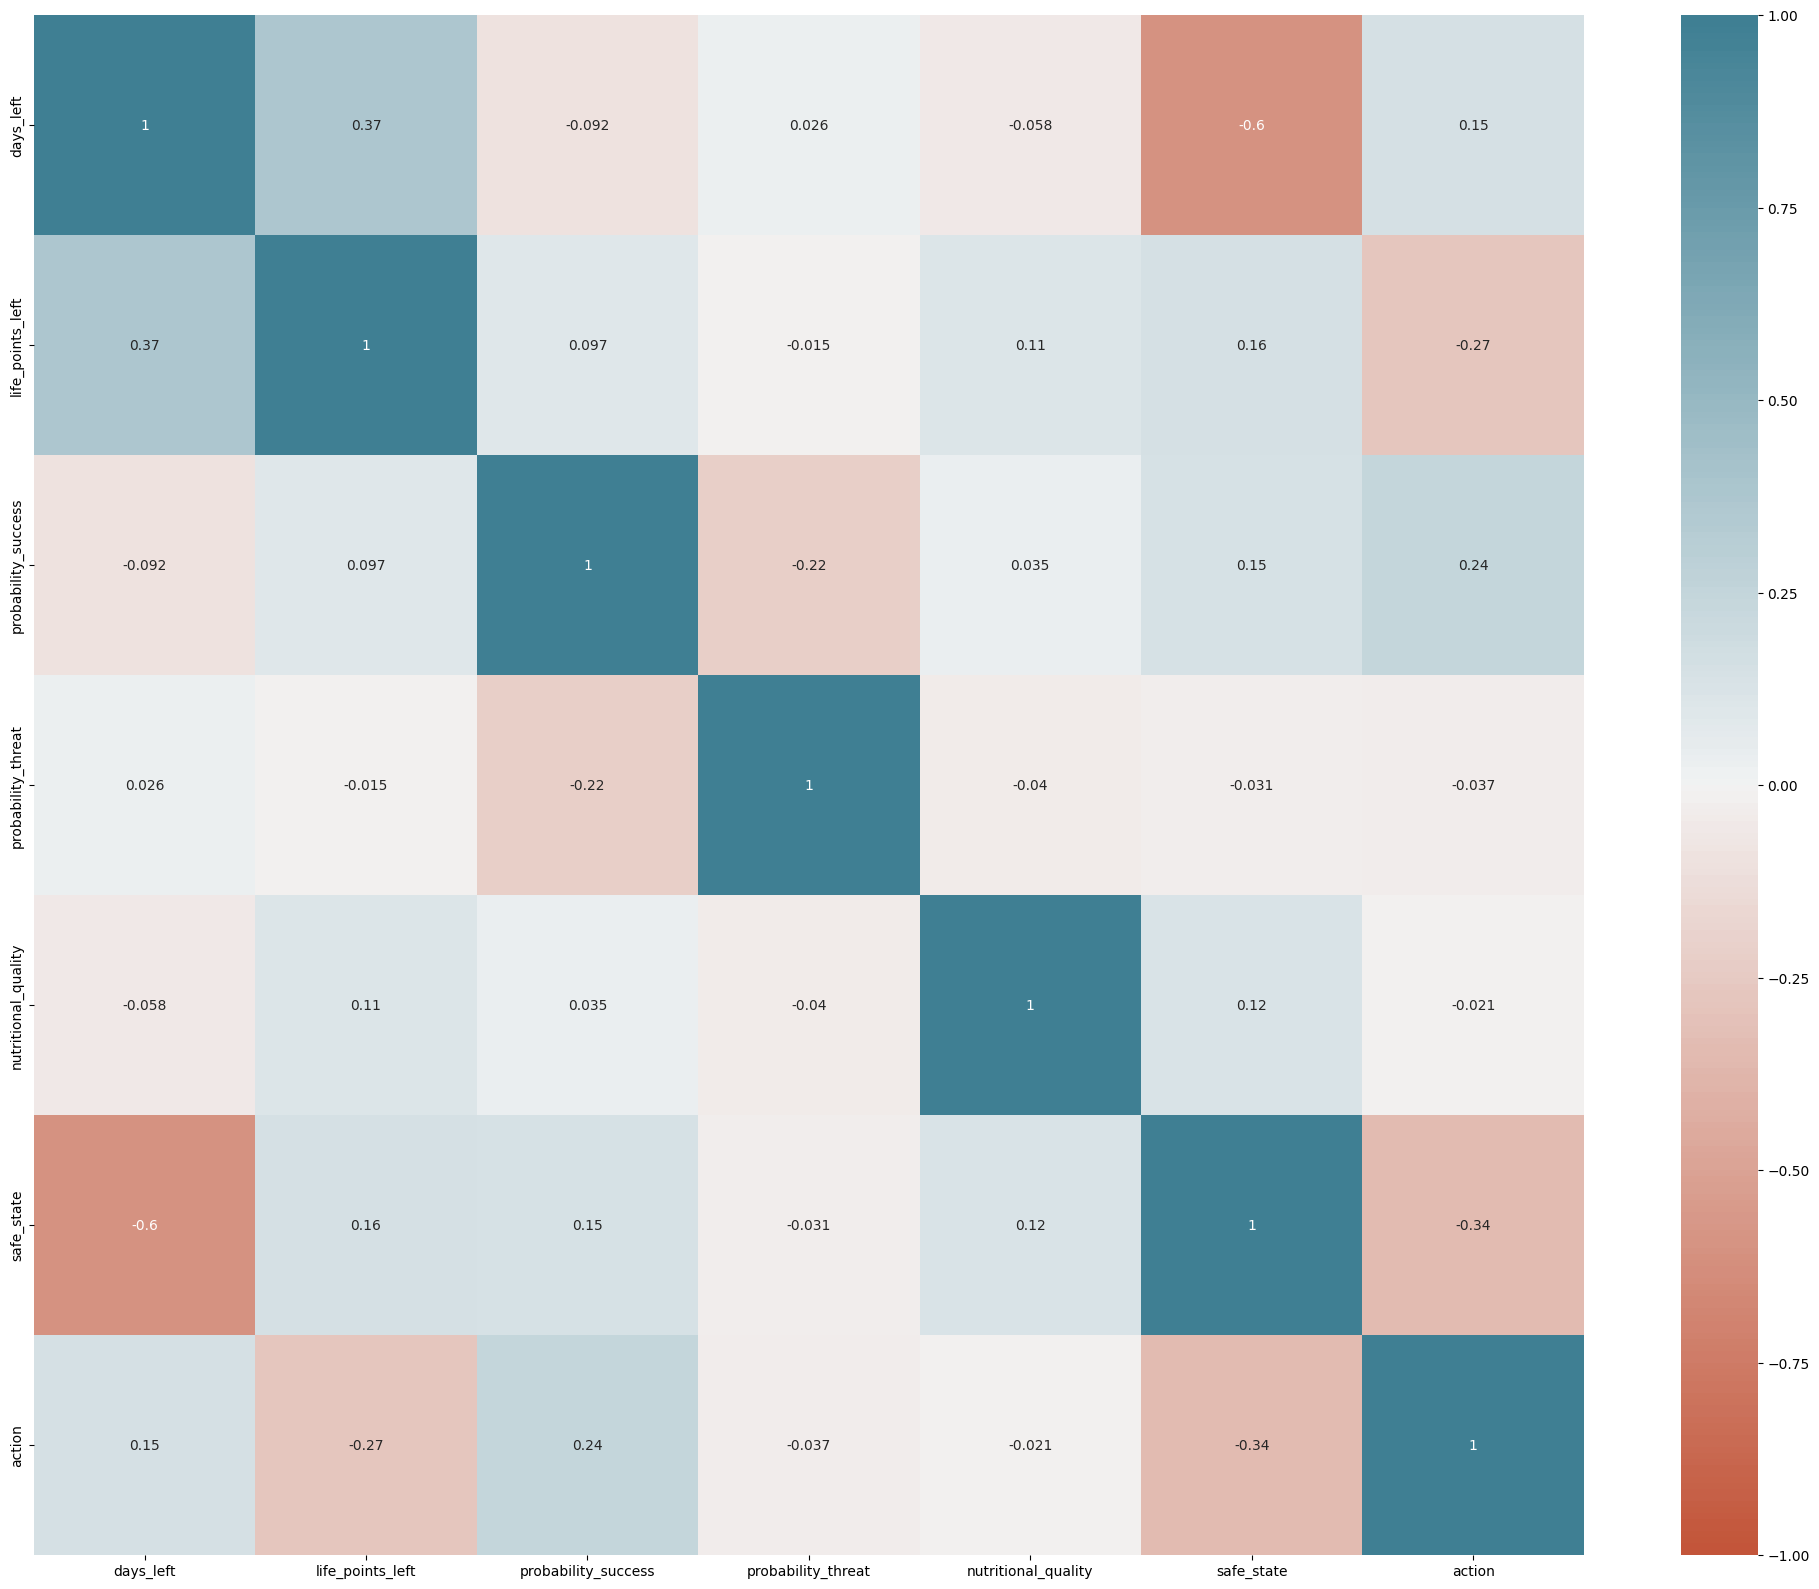

In [17]:
#@title Check correlation
corr = df.corr()
plt.figure(figsize=(25,20))
sns.heatmap(
    corr,
    annot=True,
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200)
)

In [18]:
#@title Training-validation split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [19]:
#@title Print shape
X_train.shape, X_test.shape

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


((8216, 6), (2054, 6))

In [20]:
#@title Train interpretable decision tree
clf = DecisionTreeClassifier(
    max_depth=5,
    criterion="entropy",
    min_weight_fraction_leaf=0.05,
    min_impurity_decrease=0.02,
    random_state=42,
)

clf = clf.fit(X_train, y_train)

print(
    f"validation accuracy: {clf.score(X_test, y_test):.3f}, validation roc_auc score: {roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]):.3f}"
)

validation accuracy: 0.747, validation roc_auc score: 0.789


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


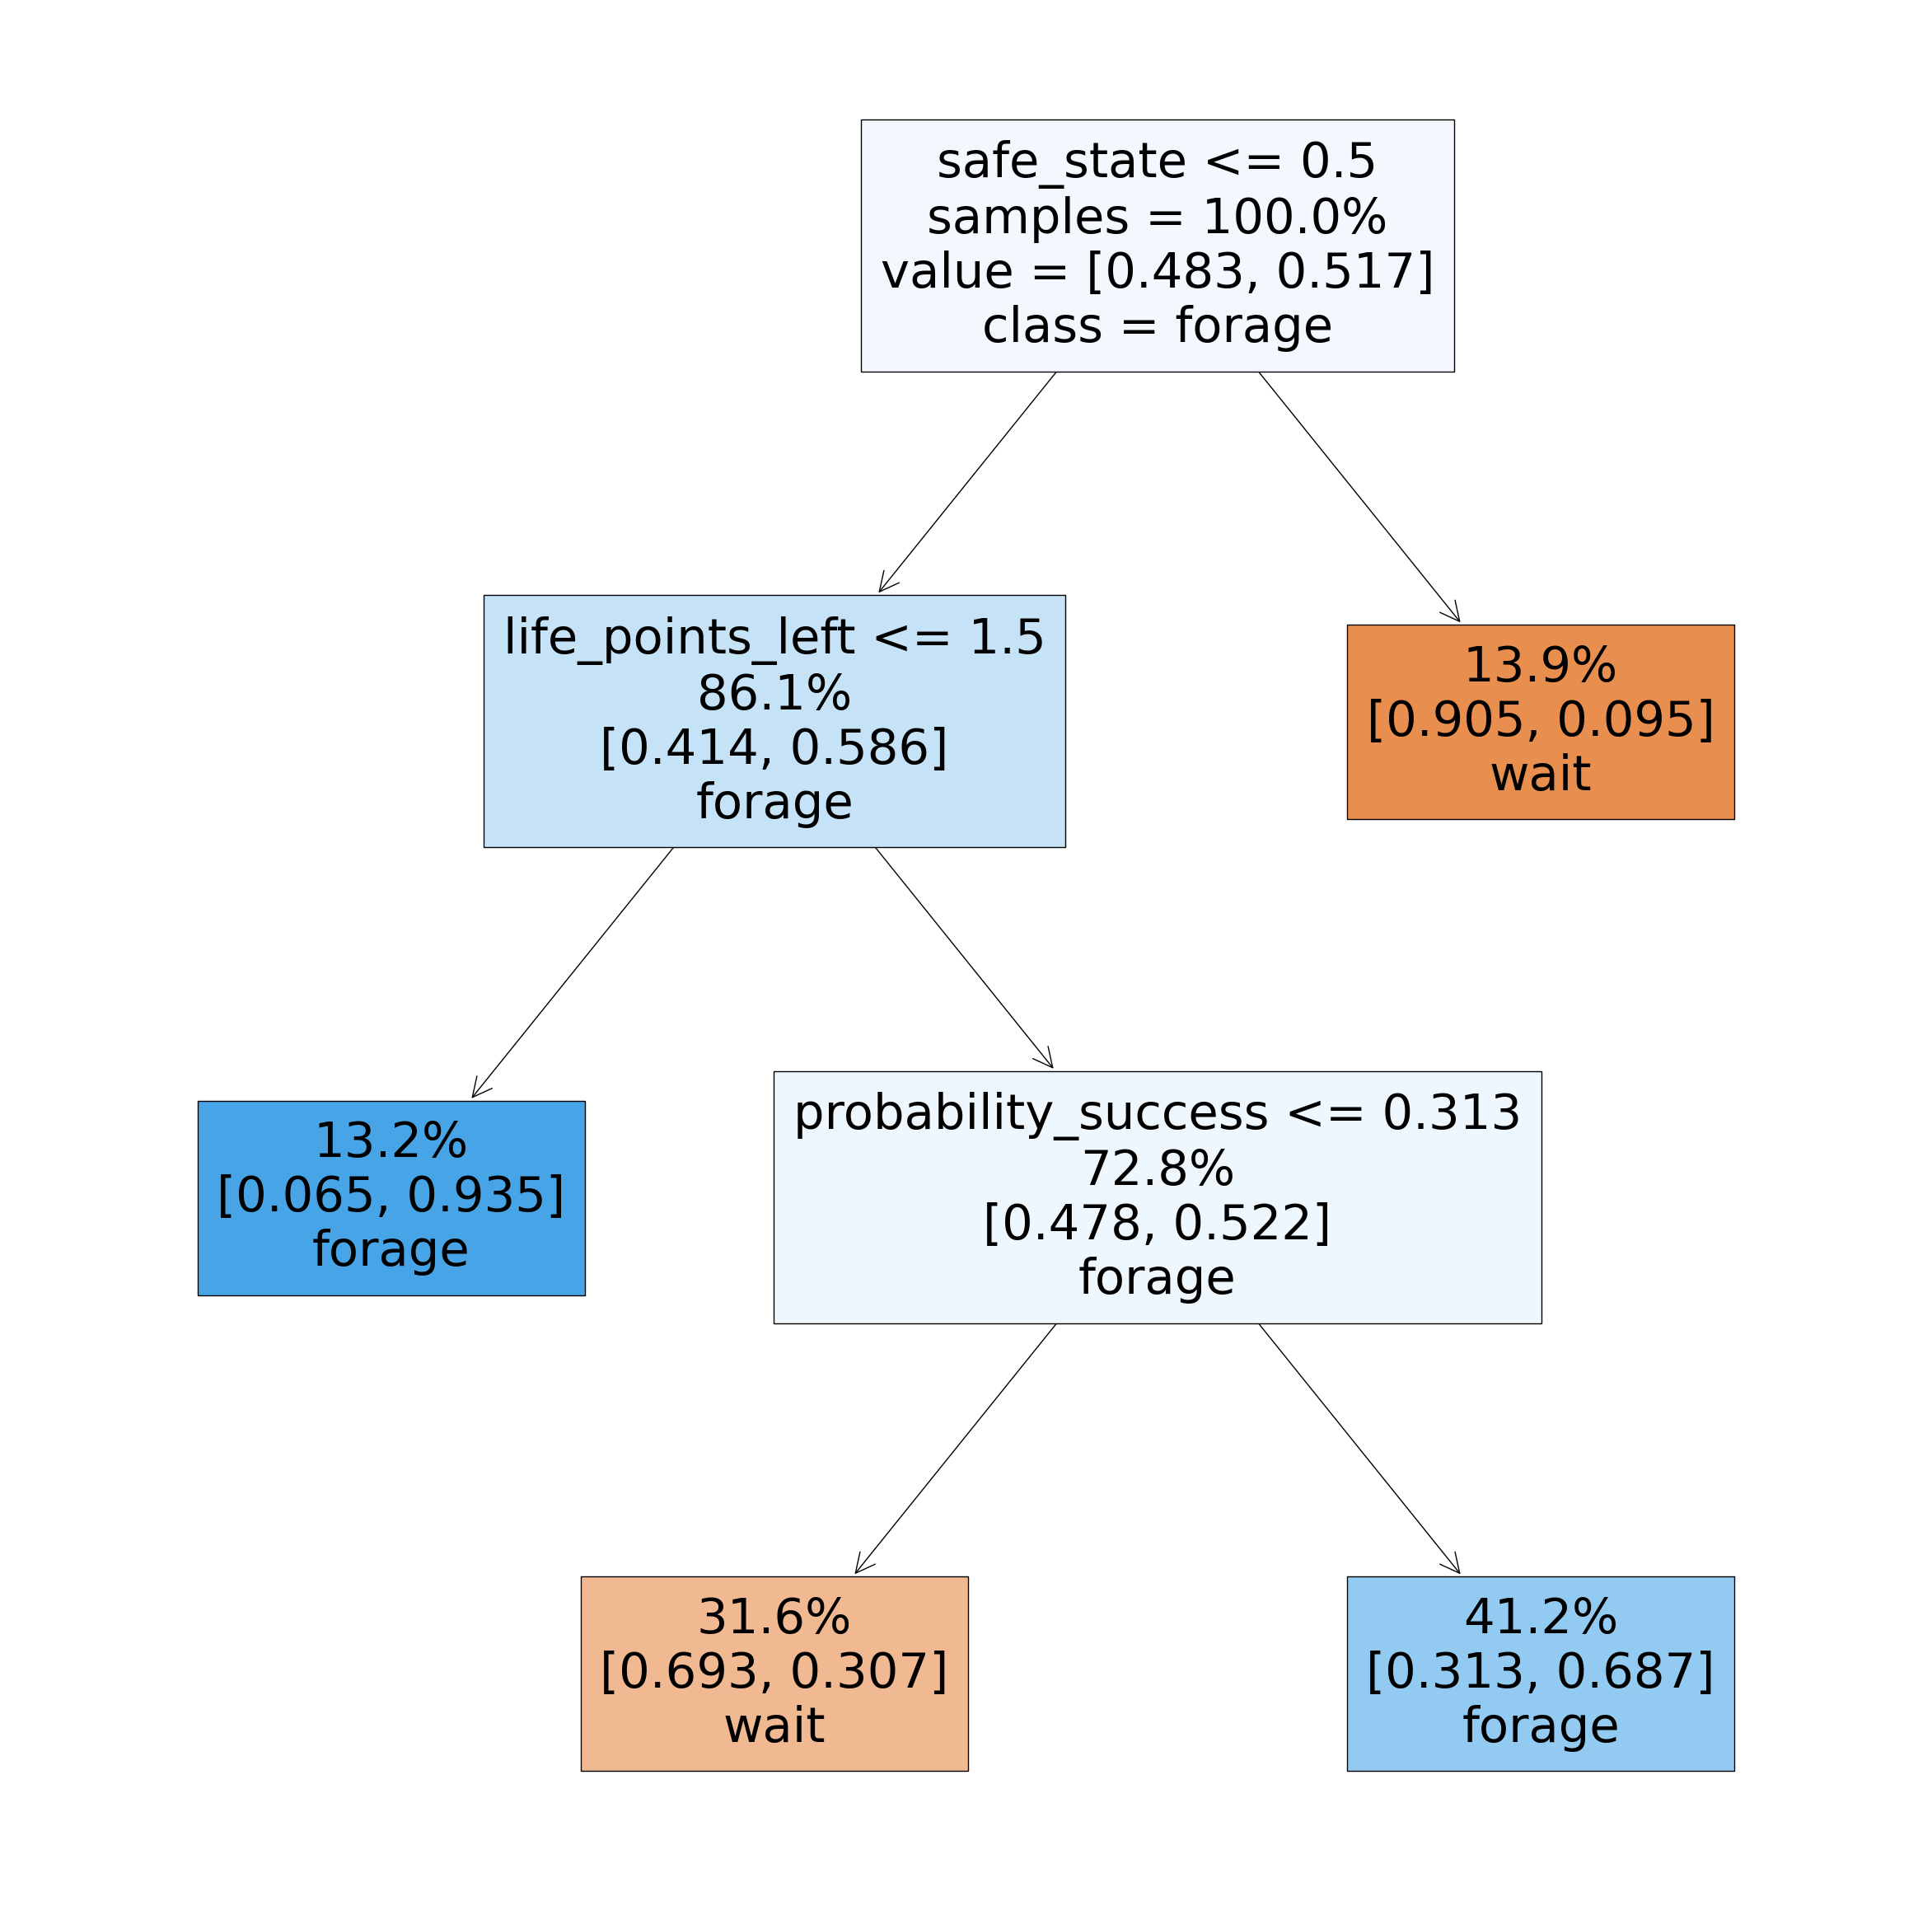

In [21]:
#@title Visualize tree
fig = plt.figure(figsize=(30, 30))
_ = tree.plot_tree(
    clf,
    feature_names=feature_names,
    class_names=target_names,
    impurity=False,
    label="root",
    proportion=True,
    filled=True
)

# 3. Solve the foraging task

In [23]:
#@title evaluate algorithm (decision tree)

def preproc(obs):
    return np.array([[
        obs["days_left"],
        obs["life_points_left"],
        obs["environment"][0] * (1 - obs["environment"][1]),
        obs["environment"][1],
        obs["environment"][2],
        int(obs["life_points_left"] > obs["days_left"])]],
        dtype="float"
    )

num_episodes = 10000
episode_rewards = []

for episode in range(num_episodes):
    done = False
    obs, info = env.reset()

    total_reward = 0

    while not done:
        action = clf.predict(preproc(obs))[0]
        obs, reward, done, _, info = env.step(action)

        total_reward += reward

    episode_rewards.append(total_reward)

episode_rewards = np.array(episode_rewards)

def print_metrics(episode_rewards):
    interval_size = 100
    num_intervals = num_episodes // interval_size

    means = []
    std_devs = []

    for i in range(0, num_episodes, interval_size):
        interval_data = episode_rewards[i:i+interval_size]
        mean = np.mean(interval_data, axis=0)
        means.append(mean)

    for i in range(num_intervals - 1):
        mean_diff = means[i+1] - means[i]
        std_devs.append(mean_diff)

    avg = (1 + np.mean(episode_rewards, axis=0)) * 100
    std_dev = np.std(std_devs, axis=0) * 100

    return avg, std_dev

avg, std_dev = print_metrics(episode_rewards)

print(f"survival rate (in %): {avg:.1f} +- {std_dev:.3f}")

survival rate (in %): 25.3 +- 6.661
